In [1]:
import numpy as np
import cvxpy as cp
import scipy as sp
from scipy.optimize import fsolve
import torch
from datetime import datetime
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import animation
from IPython.display import Image

## Simulation Parameters

In [49]:
dt = torch.Tensor([0.04])  # timestep
t = torch.Tensor([2])  # duration
m = torch.Tensor([1])  # mass
q0 = torch.Tensor([0, 0, 1])  # init pos
v0 = torch.Tensor([0, 0, 0])  # init vel
v0.requires_grad = True
force = torch.Tensor([0, 0, 0])  # init force
g = torch.Tensor([9.8])  # gravitational acceleration
mu = torch.Tensor([0.1])  # coefficient of friction of the plane
normal = torch.Tensor([0, 0, 1])  # phi(q) = n @ q

## Simulation Backend

In [3]:
class SimSystem:
    def __init__(self, q0, v0):
        self.q = q0
        self.v = v0
    
    def step_q(self, update=True):
        """ Find next q according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
        
    def step_v(self, update=True):
        """ Find next v according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
    
    def plot(self, q=None):
        """
        Generate a plot for current config (or for Q if specified)
        """
        raise NotImplementedError()
    
    @property
    def dim(self):
        return self.q.shape[0]

In [57]:
class Block2D(SimSystem):
    def __init__(self, pos, vel, mass, force, normal,
                 dt=dt, mu=mu, solver='eig0'):
        super().__init__(pos, vel)
        self.m = mass
        self.f = force
        self.n = normal
        self.dt = dt
        self.mu = mu
        self.solver = solver
        if self.n @ self.q <= 0:
            l = torch.ones(1)
            b = torch.ones(self.dim)
            g = torch.zeros(1)
        else:
            l = torch.zeros(1)
            b = torch.zeros(self.dim)
            g = torch.zeros(1)
        self.vlbg = torch.cat((self.v, l, b, g))
    
    def step_q(self, update=True):
        q_new = self.q + self.dt * self.v
        if update:
            self.q = q_new
        return q_new
    
    def step_v(self, return_all=True, update=True):
        vlbg = self.vlbg
        with torch.no_grad():
            v = cp.Variable(self.dim)
            constraints = [self.dt * (self.n @ v) >= -self.n @ self.q]
            prob = cp.Problem(cp.Minimize(0.5 * self.m * cp.norm(v, 2)**2 - self.m * v @ self.v + self.dt * g * self.m * self.n @ v), constraints)
            prob.solve(solver=self.solver)
            vlbg[:self.dim] = torch.from_numpy(v.value).float()
            vlbg[self.dim] = torch.from_numpy(constraints[0].dual_value).float()
            sol, _, success, err = fsolve(self.objective_np, vlbg.detach().numpy(),
                                         full_output=True)
            assert success == 1, f'ERROR found during scipy fsolve:\n{err}'
            assert np.allclose(np.zeros_like(sol), self.objective_np(sol))
            assert vlbg[self.dim] >= 0
            assert vlbg[-1] >= 0
            vlbg = torch.from_numpy(sol).float()
            J = self.grad_objective(sol)
        # reinsert gradients
        vlbg -= self.objective_torch(vlbg)
        # backward hook
        vlbg.register_hook(lambda grad: torch.solve(grad[:,None], J.T.float())[0][:,0])
        v_new, l, b, ga = self.split_vlbg(vlbg)
        if update:
            self.v = v_new
            self.vlbg = vlbg.detach()
        return v_new if not return_all else v_new, l, b, g
    
    def split_vlbg(self, vlbg):
        if type(vlbg) is np.ndarray:
            v, l, b, ga = np.split(vlbg, (3, 4, 7))
        elif type(vlbg) is torch.Tensor:
            v, l, b, ga = torch.split(vlbg, (3, 1, 3, 1))
        else:
            raise TypeError('Type must be np.ndarray or torch.Tensor.')
        return v, l, b, ga
    
    def objective_np(self, vlbg):
        """ assumes np input. represents g, where the goal is g(v, l, b, g) = 0"""
        v, l, b, ga = self.split_vlbg(vlbg)
        v_old, dt, n, m, q, f, mu, gnp = map(lambda x: x.detach().numpy(),
                                       (self.v, self.dt, self.n, self.m, self.q, self.f, self.mu, g))
        z1 = m * (v - v_old) - dt * n * l + m * gnp * dt
        z2 = l * (n @ (dt * v_old + q))
        z3 = (1 + ga) * b + f * dt + m * v_old
        z4 = ga * (b @ b - (mu * m * gnp)**2)
        return np.concatenate((z1, z2, z3, z4))
    
    def objective_torch(self, vlbg):
        """ assumes torch input. represents g, where the goal is g(v, l, b, g) = 0"""
        v, l, b, ga = self.split_vlbg(vlbg)
        z1 = self.m * (v - self.v) - self.dt * self.n * l + self.m * g * self.dt
        z2 = l * (self.n @ (self.dt * v + self.q))
        z3 = (1 + ga) * b + self.f * self.dt + self.m * self.v
        z4 = ga * (b @ b - (self.mu * self.m * g)**2)
        return torch.cat((z1, z2, z3, z4))
    
    def grad_objective(self, vlbg):
        normal_ = self.n.numpy()[None]  # (1, self.dim)
        v, l, b, ga = np.split(vlbg, (3, 4, 7))
        J11 = np.hstack([self.m.numpy() * np.eye(self.dim), self.dt * normal_.T])
        J12 = np.hstack([l * self.dt.numpy() * normal_, normal_ @ (self.dt.numpy() * v + self.q.numpy())[:,None]])
        J1 = torch.from_numpy(np.vstack((J11, J12))).float()
        J21 = np.hstack([(1 + ga) * np.eye(self.dim), b[:,None]])
        J22 = np.hstack([2 * ga * b[None,:], (b @ b - (self.mu * self.m * g).numpy()**2)[:,None]])
        J2 = torch.from_numpy(np.vstack((J21, J22))).float()
        J = torch.block_diag(J1, J2)
        return J
        
    def plot(self, q=None):
        if q is None:
            q = self.q
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        plt.xlim(-8, 8)
        plt.ylim(-8, 8)
        plt.plot(q[0], q[1], 'ro')
        canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return img

## Run Simulation

In [58]:
def sim(system, timesteps=10, return_all=False):
    """
    :param system: (SimSystem) initialized obj representing system,
                    including functions to update q and v
    :param timesteps: (int) number of timesteps to simulate for
    """
    qs, vs = [system.q.detach().numpy()], [system.v.detach().numpy()]
    t = 0
    if return_all:
        ls = []
        bs = []
        gs = []
    while t < timesteps:
        q = system.step_q()
        if return_all:
            v, l, b, g = system.step_v(return_all=return_all)
            ls.append(l.detach().numpy())
            bs.append(b.detach().numpy())
            gs.append(g.detach().numpy())
        else:
            v = system.step_v(return_all=return_all)
        qs.append(q.detach().numpy())
        vs.append(v.detach().numpy())
        t += system.dt
    return np.stack(qs) if not return_all else\
            np.stack(qs), np.stack(vs), np.array(ls), np.stack(bs), np.array(gs)

In [59]:
system = Block2D(q0, v0, m, force, normal, dt, solver='ECOS')
qs, vs, ls, bs, gs = sim(system, timesteps=t, return_all=True)

## Plot

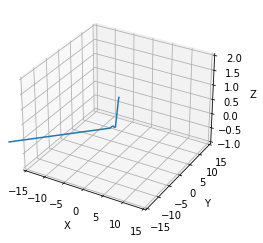

In [51]:
Writer = animation.writers['pillow']
writer = Writer(fps=int(1/dt), bitrate=600)

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

fig = plt.figure()
ax = fig.gca(projection='3d')
line, = ax.plot(qs[:1, 0], qs[:1, 1], qs[:1, 2])
ax.set_xlim3d([-15, 15])
ax.set_xlabel('X')
ax.set_ylim3d([-15, 15])
ax.set_ylabel('Y')
ax.set_zlim3d([-1, 2])
ax.set_zlabel('Z')
ani = animation.FuncAnimation(fig, update, int(t / dt), fargs=(qs.T, line), interval=dt, blit=False)
time = datetime.now().strftime('%m%d%y_%H%M%S')
filename = f'gifs/impact/sim2d_impact_{time}.gif'
ani.save(filename, writer=writer)

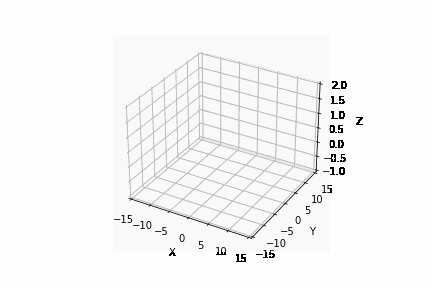

In [52]:
Image(filename=filename)

In [53]:
qs[:5]

array([[ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [-0.01568   , -0.01568   ,  0.98432   ],
       [-0.0470407 , -0.0470407 ,  0.9372786 ],
       [-0.09408139, -0.09408139,  0.8588773 ]], dtype=float32)

In [48]:
ls

array([[9.8000269e+00],
       [2.9399961e+01],
       [4.3954830e+01],
       [1.2909280e+02],
       [3.4663538e+02],
       [1.4791615e-05],
       [3.2859606e-07],
       [5.5898505e-07],
       [3.8235294e-07],
       [2.9999001e-06],
       [2.4791277e-07],
       [3.3813023e-07],
       [1.3273602e-07],
       [8.2725098e-09],
       [3.4834887e-08],
       [5.5256582e-08],
       [2.1344286e-08],
       [1.8445327e-08],
       [6.8955157e-09],
       [7.0578771e-08],
       [2.3277660e-07],
       [3.5030329e-08],
       [7.1979613e-08],
       [6.8031394e-09],
       [5.1005195e-08],
       [2.4982988e-08],
       [2.1585276e-08],
       [4.6961492e-08],
       [5.4882565e-09],
       [4.8460748e-08],
       [4.5087085e-09],
       [5.5461911e-09],
       [3.5576087e-09],
       [3.2306455e-09],
       [3.5630687e-09],
       [3.5051864e-09],
       [9.4564898e-09],
       [2.0717138e-07],
       [1.9513557e-07],
       [1.2750492e-07],
       [1.6740212e-07],
       [2.323049